In [3]:
import os, sys

sys.path.append("/home/yupeng.jia/Projects/worldmodel/thirdparty/pytorch3d")

In [1]:
import torch
import trimesh
import numpy as np
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex
from pytorch3d.vis.plotly_vis import plot_scene
# 1. 使用 Trimesh 加载 PLY (因为它能稳定读取颜色)
scene = trimesh.load("/home/yupeng.jia/Projects/worldmodel/a.glb")
scene.geometry["geometry_0"].export("/home/yupeng.jia/Projects/worldmodel/a.ply")
mesh_tm = trimesh.load("/home/yupeng.jia/Projects/worldmodel/a.ply")
# 2. 提取数据并转为 Torch Tensor
# PyTorch3D 需要 float32 类型
verts = torch.tensor(mesh_tm.vertices, dtype=torch.float32).cuda()
faces = torch.tensor(mesh_tm.faces, dtype=torch.int64).cuda()
# 3. 处理颜色 (关键步骤)
# Trimesh 读取的颜色通常是 (N, 4) rgba uint8 [0-255]
# PyTorch3D 需要 (1, N, 3) rgb float [0-1]
colors = mesh_tm.visual.vertex_colors[:, :3] # 取前3通道 RGB，忽略 Alpha
colors = torch.tensor(colors, dtype=torch.float32).cuda() / 255.0 # 归一化到 0-1
# 4. 构建 PyTorch3D 的 Meshes 对象
# 注意：Meshes 接受的是 list，因为它可以处理 batch
mesh_pytorch3d = Meshes(
    verts=[verts], 
    faces=[faces], 
    textures=TexturesVertex(verts_features=[colors]) # 显式指定这是顶点颜色
)
# 5. 可视化
# 这会在 Jupyter 中显示交互式窗口，或者生成 HTML
# plot_scene({
#     "Model Check": {
#         "my_mesh": mesh_pytorch3d
#     }
# })

/opt/conda/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


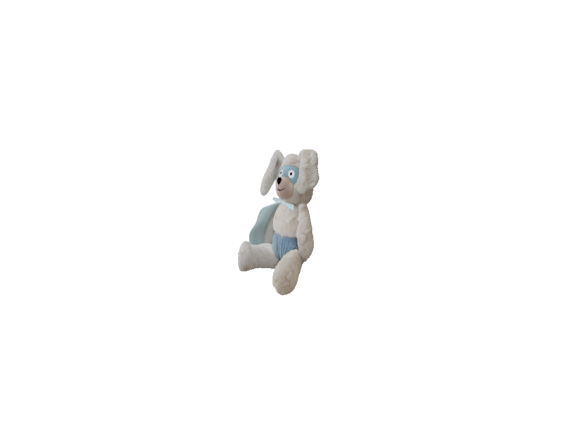

In [5]:
import torch
import trimesh
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    TexturesVertex,
    look_at_view_transform,
    PerspectiveCameras, 
    PointLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader
)
from pytorch3d.renderer.cylindercameras import CylinderCameras

import torch.nn as nn
from pytorch3d.renderer import BlendParams, hard_rgb_blend

class SimpleShader(nn.Module):
    def __init__(self, blend_params=None):
        super().__init__()
        self.blend_params = blend_params if blend_params is not None else BlendParams()

    def forward(self, fragments, meshes, **kwargs):
        # 1. 采样纹理 (Sample textures)
        # 这一步会根据光栅化得到的 fragments（碎片/像素对应的面片信息）
        # 自动插值顶点颜色 或者 在 UV 贴图上采样颜色。
        # 返回的 texels 形状通常为 (N, H, W, K, C)，此处 K=1
        texels = meshes.sample_textures(fragments)
        
        # 2. 混合 (Blending)
        # 因为我们要“完全遵守原本颜色”，不需要半透明或柔和边缘，
        # 所以使用 hard_rgb_blend。它会直接取最靠近相机的那个像素颜色，
        # 对于没有模型的区域使用背景色填充。
        images = hard_rgb_blend(texels, fragments, self.blend_params)
        
        return images



# --- 1. 数据加载与构建 (同上) ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
verts = torch.tensor(mesh_tm.vertices, dtype=torch.float32).to(device)
faces = torch.tensor(mesh_tm.faces, dtype=torch.int64).to(device)
colors = torch.tensor(mesh_tm.visual.vertex_colors[:, :3], dtype=torch.float32).to(device) / 255.0
# 构建 Meshes
mesh = Meshes(
    verts=[verts], 
    faces=[faces], 
    textures=TexturesVertex(verts_features=[colors])
)
# --- 2. 设置虚拟相机 ---
# 调整 dist (距离) 和 elev, azim (角度) 以看清模型
R, T = look_at_view_transform(dist=2.5, elev=10, azim=45) 
# K = torch.tensor([
#     [586.708782213963, 0, 512.0, 0,],
#     [ 0, 586.708782213963, 384.0, 0,],
#     [ 0, 0, 0, 1,],
#     [ 0, 0, 1, 0]], dtype=torch.float32).to(device)
# K[0] /= 1024.0
# K[1] /= 768.0
# K = K[None]
# cameras = PerspectiveCameras(device=device, R=R, T=T)#, K=K)
def get_ndc_K(image_size, focal_length, principal_point, device="cuda"):
    H, W = image_size
    fx_screen, fy_screen = focal_length
    cx_screen, cy_screen = principal_point
    fx_ndc = fx_screen * (2.0 / W)
    fy_ndc = fy_screen * (2.0 / H)
    cx_ndc = (cx_screen / W) * 2.0 - 1.0
    cy_ndc = (cy_screen / H) * 2.0 - 1.0
    K = torch.zeros((1, 4, 4), dtype=torch.float32, device=device)
    K[0, 0, 0] = fx_ndc
    K[0, 1, 1] = fy_ndc
    K[0, 0, 2] = cx_ndc
    K[0, 1, 2] = cy_ndc
    K[0, 2, 3] = 1.0 
    K[0, 3, 2] = 1.0 
    return K
focal_length = torch.tensor([[586.708782213963, 586.708782213963]], dtype=torch.float32, device=device)
principal_point = torch.tensor([[512.0, 384.0]], dtype=torch.float32, device=device)
image_size = torch.tensor([[768, 1024]], dtype=torch.float32, device=device) # (H, W)
K = get_ndc_K(image_size[0].tolist(), focal_length[0].tolist(), principal_point[0].tolist(), device=device)
cameras = CylinderCameras(device=device, R=R, T=T, K=K)
# --- 3. 设置灯光 ---
# 如果没有灯光，模型可能是全黑的
lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])
# --- 4. 若要清晰显示顶点颜色，这里有个技巧 ---
# 使用 SoftPhongShader 会受光照影响（有阴影）
# 如果你想看原本的颜色（不带阴影），需要自定义 Shader 
# 但通常 SoftPhongShader 配合合适的灯光效果最好
raster_settings = RasterizationSettings(
    image_size=(768, 1024), 
    blur_radius=0.0, 
    faces_per_pixel=1,
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SimpleShader()
    # shader=SoftPhongShader(
    #     device=device, 
    #     cameras=cameras,
    #     lights=lights
    # )
)
# --- 5. 渲染 ---
with torch.no_grad():
    images = renderer(mesh)
# --- 6. 显示结果 ---
plt.figure(figsize=(7, 7))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.show()